In [32]:
import numpy as np
import pandas as pd
import os
import json
import torch
from torchvision import models
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import copy
from tqdm import tqdm 
from rich.progress import Progress
import timm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import wandb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [33]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  
    np.random.seed(seed) 
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  

seed_everything(23)

In [34]:
ROOT = '../Datasets'
TEST_IMAGES_PATH = os.path.join(ROOT, 'test_images')
test = pd.DataFrame()
test['image_id'] = list(os.listdir('../Datasets/test_images/'))
test['path'] = TEST_IMAGES_PATH + '/' + test['image_id']


In [35]:
test

,image_id,path
0,2216849948.jpg,../Datasets/test_images/2216849948.jpg


In [36]:
#### DEFINE DATASET
ROOT = '../Datasets'
TRAIN_IMAGES_PATH = os.path.join(ROOT, 'train_images')
train_df = pd.read_csv(os.path.join(ROOT, 'train.csv'))
train_df['path'] = TRAIN_IMAGES_PATH + '/' + train_df['image_id']


class CassavaDataset(Dataset):
    
    def __init__(self, df, transform=None, output_label=True):
        self.df = df.reset_index(drop=True)  # Reset the index
        #self.df = df
        self.transform = transform
        self.output_label = output_label
  
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #print("index is " , index)
        if index >= len(self.df):
            raise IndexError('Index out of range')
        img = Image.open(self.df['path'][index])
                
        if self.transform:
            img = self.transform(img)
        
        if self.output_label:
            label = torch.tensor(self.df['label'][index], dtype=torch.long)
            return img, label
        else:
            return img


In [37]:
test_dataset = CassavaDataset(test,output_label=False)

In [38]:
test_dataset[0]

AttributeError: 'CassavaDataset' object has no attribute 'output_label'

In [12]:
WIDTH = 128 #224 for ViT
HEIGHT = 128 #224
NUM_CLASSES = 5
BATCH_SIZE = 16
model_name = "efficientnet_b0"
num_epochs = 2
patience = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {DEVICE}')

Device: cuda


In [5]:
def get_model(name):
    
    if name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        
        in_feat = model.fc.in_features
        
        model.fc = nn.Sequential(
              nn.Linear(in_feat, NUM_CLASSES)
              )
    elif name =="efficientnet_b0":
        model = timm.create_model('efficientnet_b0', pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(classifier_input_features, num_classes) 
        )
    elif name =="efficientnet_b3":
        model = timm.create_model('efficientnet_b3', pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(classifier_input_features, num_classes) 
        )
    elif name == "efficientnet_b4":
        model = timm.create_model('tf_efficientnet_b4_ns',pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        num_classes = 5  
        classifier_input_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(classifier_input_features, num_classes)
        )
    elif name == "vit":
        model = timm.create_model("vit_base_patch16_224", pretrained=True)
        num_classes = 5

        classifier_input_features = model.head.in_features
        model.head = nn.Linear(classifier_input_features, num_classes)
        
    model = model.to(DEVICE)
    
    return model

In [6]:
data_transform =  transforms.Compose([
    transforms.RandomResizedCrop((WIDTH, HEIGHT)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

In [7]:
train_df = CassavaDataset(train_df, transform=data_transform)

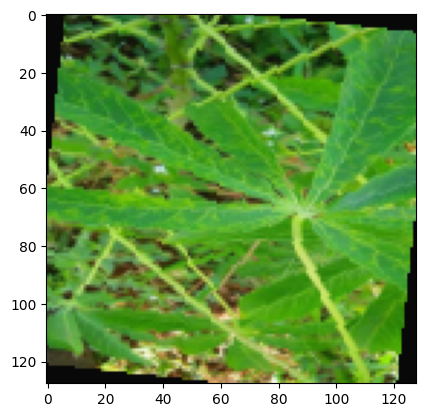

In [8]:
plt.imshow(train_df[3][0].permute(1,2,0))

In [9]:
sk = StratifiedKFold(n_splits=5, random_state=23, shuffle=True)

for fold, (train, val) in enumerate(sk.split(train_df, train_df.label)):
    train_df.loc[val, 'fold'] = fold
    #reset the index after filtering the df based on fold numbers
    train_data = train_df[train_df['fold'] != fold].reset_index(drop=True)
    val_data = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_dataset = CassavaDataset(train_data, transform=data_transform)
    val_dataset = CassavaDataset(val_data, transform=data_transform)

    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    
    print(train_data)
    for epoch in range(num_epochs):
        print("fold is ", fold+1,"epoch is ", epoch+1)
        for x_batch, y_batch in train_dl:
                print(x_batch.shape)
                plt.plot(x_batch)
                break

    
    
#train_df.fold = train_df.fold.astype(int)


             image_id  label                                  path  fold
0      1000015157.jpg      0  Datasets/train_images/1000015157.jpg   NaN
1      1000201771.jpg      3  Datasets/train_images/1000201771.jpg   NaN
2       100042118.jpg      1   Datasets/train_images/100042118.jpg   NaN
3      1000723321.jpg      1  Datasets/train_images/1000723321.jpg   NaN
4      1000812911.jpg      3  Datasets/train_images/1000812911.jpg   NaN
...               ...    ...                                   ...   ...
17112   998910982.jpg      1   Datasets/train_images/998910982.jpg   NaN
17113   999068805.jpg      3   Datasets/train_images/999068805.jpg   NaN
17114   999329392.jpg      3   Datasets/train_images/999329392.jpg   NaN
17115   999474432.jpg      1   Datasets/train_images/999474432.jpg   NaN
17116   999998473.jpg      4   Datasets/train_images/999998473.jpg   NaN

[17117 rows x 4 columns]
fold is  1 epoch is  1


TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>

In [10]:
train_df

,image_id,label,path,fold
0,1000015157.jpg,0,Datasets/train_images/1000015157.jpg,0
1,1000201771.jpg,3,Datasets/train_images/1000201771.jpg,1
2,100042118.jpg,1,Datasets/train_images/100042118.jpg,3
3,1000723321.jpg,1,Datasets/train_images/1000723321.jpg,0
4,1000812911.jpg,3,Datasets/train_images/1000812911.jpg,1
...,...,...,...,...
21392,999068805.jpg,3,Datasets/train_images/999068805.jpg,2
21393,999329392.jpg,3,Datasets/train_images/999329392.jpg,3
21394,999474432.jpg,1,Datasets/train_images/999474432.jpg,1
21395,999616605.jpg,4,Datasets/train_images/999616605.jpg,0


In [ ]:
num_folds = 5

for fold in range(num_folds):

    train_df = split_dataset_kfold(train_df, num_folds)

    train_data = train_df[train_df['fold'] != fold]
    val_data = train_df[train_df['fold'] == fold]
    
    # Create PyTorch datasets
    train_dataset = CassavaDataset(train_data, transform=data_transform)
    val_dataset = CassavaDataset(val_data, transform=data_transform)
    
    # Create PyTorch data loaders
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    #with Progress() as progress:
        #training_task = progress.add_task("[red]Training...", total=num_epochs*len(train_dl))
        
    for epoch in range(num_epochs):
        print(epoch)